In [1]:
ARTICLES_LOAD_ROOT = "../../data-2023/raw/articles/articles"

In [372]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import random
import json
import razdel
import re
import matplotlib.pyplot as plt
import xxhash

In [3]:
import torch
from transformers import AutoTokenizer, AutoModel

In [4]:
model_name = "slone/LaBSE-en-ru-myv-v2"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).cuda();

In [441]:
import slone_nmt.document_alignment
from importlib import reload
reload(slone_nmt.document_alignment)

from slone_nmt.document_alignment import align3, embed, get_penalized_sims, align_docs

# looking at the data

In [13]:
filenames = os.listdir(ARTICLES_LOAD_ROOT)
print(len(filenames))

4075


In [27]:
fn2data = {}
for fn in tqdm(filenames):
    if not fn.endswith('.json'):
        continue
    with open(f"{ARTICLES_LOAD_ROOT}/{fn}", "r", encoding='utf-8') as f:
        item = json.load(f)
    fn2data[fn] = item

  0%|          | 0/4075 [00:00<?, ?it/s]

In [38]:
print({tuple(item.keys()) for item in fn2data.values()})

{('article_erz', 'article_rus_candidates')}


In [50]:
pd.Series([len(item['article_rus_candidates']) for item in fn2data.values()]).value_counts().sort_index()

0     571
1    3317
2     137
3      36
4       9
5       2
8       2
dtype: int64

In [81]:
# check that each text starts with the line like "15 февраля 2022"
for item in fn2data.values():
    src_text = item['article_erz']['text']
    assert re.match("[\d]{1,2} [a-я]+[ая] [\d]{4}\n", src_text)
    for cand in item['article_rus_candidates']:
        assert re.match("[\d]{1,2} [a-я]+[ая] [\d]{4}\n", cand['text'] + '\n')

In [469]:
def resentenize_article(text):
    lines = text.split('\n')[1:]  # skip the first line, which is always just the date
    if len(lines) == 0:
        return []
    if lines[-1] in {
        'Пресс-служба Главы Республики Мордовия', 
        'Мордовия Республикань Прявтонть пресс-службась', 
        'Мордовия Республикань Прявтонь пресс-службась'
    }:
        lines = lines[:-1]
    return [sent.text for sent in razdel.sentenize(' '.join(lines))]

## Playing with examples

In [457]:
fn = random.choice(list(fn2data.keys()))
print(fn)
item = fn2data[fn]
print(item.keys())
print(len(item['article_rus_candidates']))

article_3768.json
dict_keys(['article_erz', 'article_rus_candidates'])
2


In [470]:
src_text = item['article_erz']['text']
tgt_text = item['article_rus_candidates'][0]['text']

In [471]:
src_sents = resentenize_article(src_text)
tgt_sents = resentenize_article(tgt_text)

In [472]:
%%time

src_embs = embed(src_sents, model, tokenizer)
tgt_embs = embed(tgt_sents, model, tokenizer)

ValueError: need at least one array to concatenate

(7, 7)
7


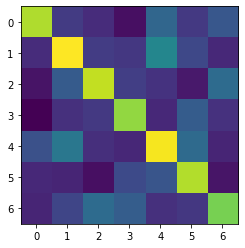

In [461]:
sims, sims_rel = get_penalized_sims(src_sents, tgt_sents, src_embs, tgt_embs, rel_penalty=0.2, abs_penalty=0.2)

print(sims_rel.shape)
pair_ids = align3(sims_rel)
print(len(pair_ids))
plt.imshow(sims_rel);

In [462]:
pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 200

In [463]:
doc_df = align_docs(src_sents, tgt_sents, pair_ids, sims, sims_rel)
doc_df['src_doc_hash'] = xxhash.xxh3_64_hexdigest(item['article_erz']['link'])
doc_df['tgt_doc_hash'] = xxhash.xxh3_64_hexdigest(cand['link'])
doc_df['docs_sim'] = doc_df.sim.fillna(0).mean()

print('mean aligned penalized sim:', doc_df.sim_pnlz.mean())
print('mean gross raw sim:        ', doc_df.sim.fillna(0).mean())


doc_df

mean aligned penalized sim: 0.46136250730188194
mean gross raw sim:         0.818253997358546


,src_sent_id,src_sent,tgt_sent_id,tgt_sent,sim,sim_pnlz,src_doc_hash,tgt_doc_hash,docs_sim
0,0,Мордовиянь Прявтось Владимир Волков ноябрянь 14-це чистэ ютавтсь зярыя вастовомат Московсо.,0,Глава Мордовии Владимир Волков 14 ноября провел ряд рабочих встреч в Москве.,0.789928,0.446849,10bed7912eb506fb,593f0069fd2ae398,0.818254
1,1,Вастовкшнось Россиянь финансонь министерствань межбюджетной отношениятнень департаментэнь прявтонть Лариса Ерошкина марто.,1,Состоялась встреча с руководителем департамента межбюджетных отношений министерства финансов России Ларисой Ерошкиной.,0.917278,0.542011,10bed7912eb506fb,593f0069fd2ae398,0.818254
2,2,Кортавсть финансонь иень прядовоманть туртов республикантень лезксэнь явомань кевкстематне.,2,Обсуждались вопросы оказания поддержки республике для завершения финансового года.,0.824726,0.468978,10bed7912eb506fb,593f0069fd2ae398,0.818254
3,3,"Истя жо мольсь кортамо 2018 иень футболонь коряс масторлангонь чемпионатонтень анокстамонь мероприятиятнень финансированиядост, истя жо коммерческой займамотнень полавтоманть туртов бюджетэнь кредитэнь получамодо.",3,"В том числе речь шла о финансировании мероприятий подготовки к чемпионату мира по футболу 2018 года, а также получении бюджетного кредита на замещение коммерческих займов.",0.753850,0.412966,10bed7912eb506fb,593f0069fd2ae398,0.818254
4,4,Вастовомасонть ульнесь Мордовия Республикань Правительствань Председателень полавтыцясь - Финансонь министрась Алексей Симонов.,4,В рабочей встрече принял участие заместитель Председателя Правительства – министр финансов Республики Мордовия Алексей Симонов.,0.913352,0.530075,10bed7912eb506fb,593f0069fd2ae398,0.818254
5,5,"Владимир Волков истя жо вастовкшнось ""Альфа-Банконь"" Прявттнэнь советэнь председателень васенце полавтыцянть Олег Сысуев марто ды кортась мартонзо республиканть ды банконть вейсэнь важодемань виевгавтомань кевкстематнеде.",5,Также Владимир Волков встретился с первым заместителем председателя Совета директоров «Альфа-Банка» Олегом Сысуевым и обсудил с ним вопросы развития сотрудничества республики и банка.,0.800758,0.450117,10bed7912eb506fb,593f0069fd2ae398,0.818254
6,6,Истя жо кортамось мольсь промышленностень ды велень хозяйствань прявт проекттнэнь туртов кредитэнь максомадо.,6,В том числе речь шла о кредитовании ряда важных проектов в промышленности и сельском хозяйстве.,0.727886,0.378541,10bed7912eb506fb,593f0069fd2ae398,0.818254


## Running it for the whole data

In [516]:
print(sum(len(resentenize_article(item['article_erz']['text'])) for item in fn2data.values()))

70433


In [517]:
aligned_docs = []

for fn in tqdm(list(fn2data.keys())):
    item = fn2data[fn]
    src_text = item['article_erz']['text']
    for cand in item['article_rus_candidates']:
        tgt_text = cand['text']
        tgt_doc_id = xxhash.xxh3_64_intdigest(cand['link'])
        
        src_sents = resentenize_article(src_text)
        tgt_sents = resentenize_article(tgt_text)
        if len(tgt_sents) == 0:  # yes, this shit sometimes happens
            continue
        src_embs = embed(src_sents, model, tokenizer)
        tgt_embs = embed(tgt_sents, model, tokenizer)

        sims, sims_rel = get_penalized_sims(src_sents, tgt_sents, src_embs, tgt_embs, rel_penalty=0.2, abs_penalty=0.2)
        pair_ids = align3(sims_rel)
        
        doc_df = align_docs(src_sents, tgt_sents, pair_ids, sims, sims_rel)
        doc_df['src_doc_hash'] = xxhash.xxh3_64_hexdigest(item['article_erz']['link'])
        doc_df['tgt_doc_hash'] = xxhash.xxh3_64_hexdigest(cand['link'])
        doc_df['docs_sim'] = doc_df.sim.fillna(0).mean()
        doc_df['src_id'] = int(fn[8:-5])
        
        aligned_docs.append(doc_df)

  0%|          | 0/4074 [00:00<?, ?it/s]

In [518]:
total_doc = pd.concat(aligned_docs, ignore_index=True)
print(total_doc.shape)
print(total_doc.dropna().shape)

(76400, 10)
(57405, 10)


In [519]:
total_doc.sample(10)

,src_sent_id,src_sent,tgt_sent_id,tgt_sent,sim,sim_pnlz,src_doc_hash,tgt_doc_hash,docs_sim,src_id
24645,3.0,"Од заводсонть топавтови вишка сортонь чувтонть отходтомо переработкась, чувтонь отходтнэнь утилизациясь ды уштомань гранулатнень нолдамось, те эряви аволь ансяк предприятиянть туртов, истя жо канды покш смусть Мордовиянь чувтонь переработкань весе отраслянть туртов.",3.0,"На новом заводе будет создана комплексная безотходная переработка низкосортной древесины, утилизация древесных отходов и выпуск топливных гранул, что важно не только для самого предприятия, но и имеет большое значение для всей деревообрабатывающей отрасли Мордовии.",0.891991,0.504467,4e8e758ba9e5162c,ad568b5205335fe6,0.708416,1307
26619,0.0,Эйзюрковонь 31-це чистэ Мордовиянь Прявтось Артём Здунов тешкстась Указ Образованиянь министракс Елена Солдатовань аравтомадонзо.,0.0,31 марта Главой Мордовии Артёмом Здуновым подписан Указ о назначении на должность Министра образования Елены Солдатовой.,0.806734,0.443940,d8c9c75ae42fcbbb,5106d524158fb55c,0.697077,1430
52140,0.0,"Пецясто, сундерьковонь 15-це чистэ, Республикань культурань дворецссэ ютавтовсь Велень хозяйствань ды перерабатывающей промышленностень важодицянь чинтень алтазь кенярксчи.",NaN,NaN,NaN,NaN,07787e95c76d2303,4106754a99ab54ff,0.050387,3012
73186,117.0,"Тень вельде велетнесэ строязь ды витнезь кинь 20 ламо километрат, витнезь китне велень хозяйствань продукциянь производствань ды переработкань объекттнэнь видьс.",NaN,NaN,NaN,NaN,17de74d1b7a8bbac,4585a92b222b7af4,0.057602,3971
25179,13.0,Аватнень ды сыре ломантнень марто вейсэ тылсэ покш сталмонть кандсть войнань эйкакштне.,13.0,Вместе с женщинами и стариками тяжелую ношу в тылу несли быстро повзрослевшие дети войны.,0.851429,0.459013,ede3428900f598f4,54586cbb1db0edb3,0.795758,1339
57768,14.0,"Кортамс марто вейке кельсэ, ванномс те эли тона кевкстематнень ды неень шкантень ладиця технологиятнень», - тешкстызе «Оптиковолоконные Системы» АО-нь генеральной прявтось Андрей Николаев.",14.0,"Разговаривать с ними на одном языке и компетентно обсуждать те или иные проблемы и современные технологии», - подчеркнул генеральный директор АО «Оптиковолоконные системы» Андрей Николаев.",0.923925,0.509879,6abcc5617fbb247a,e2830aed2ad1556c,0.779665,3279
47369,1.0,Медицинской маскатнень экшстэ а неявить мизолкстнэ.,1.0,Из-под медицинских масок не видно улыбок.,0.673439,0.339253,d9cc9be844f9a983,60f62168595f9680,0.325222,2799
43099,23.0,"Мордовиянь Финансонь министрантень Сергей Тюркиннэнь кармавтозель тень кувалма ванномс ПДД-нь коламотнень кувалма административной штрафтнень республикань бюджетс пачтямонть: «Варштадо тень лангс, республикань финанстнэнь шумбралгавтомань программасонть тынь путтадо те пунктонть, мон сонзэ зярс ...",24.0,"Министру финансов Мордовии Сергею Тюркину в этой связи поручено разобраться с поступлением административных штрафов за нарушения ПДД в бюджет республики: «Обратите на это внимание, в программе оздоровления финансов республики вы ставите этот пункт, а я пока выполнения не вижу».",0.862900,0.489051,8d66a06f4c360425,72a4dbb63349b0f6,0.716698,2532
64404,0.0,Мордовиясь саизе колмоце тарканть социально-политической паро лув марто регионтнэнь ютксо.,0.0,Мордовия заняла третье место в группе регионов с максимальной социально-политической устойчивостью.,0.816746,0.456742,a757065d85394a0a,993a3086b4b04bed,0.831863,3556
1926,10.0,«Минь вейсэ!»,NaN,NaN,NaN,NaN,fb4a4e949892991d,75a0b733c229ed3b,0.070921,92


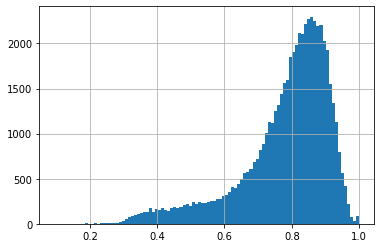

In [520]:
total_doc.sim.hist(bins=100);

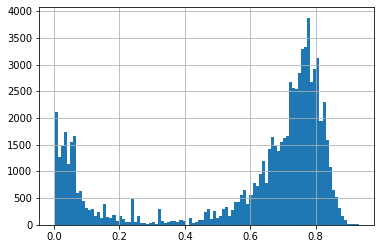

In [521]:
total_doc.docs_sim.hist(bins=100);

In [522]:
total_doc.describe()

,src_sent_id,tgt_sent_id,sim,sim_pnlz,docs_sim,src_id
count,64809.000000,68996.000000,57405.000000,57405.000000,76400.000000,76400.000000
mean,17.123393,34.259305,0.780551,0.410816,0.586486,2120.939725
std,27.735198,103.646288,0.133926,0.121365,0.283416,1236.720796
min,0.000000,0.000000,0.095246,-0.200625,0.001989,0.000000
25%,4.000000,4.000000,0.727776,0.361836,0.532172,974.000000
50%,9.000000,10.000000,0.814990,0.438253,0.720006,2161.000000
75%,18.000000,21.000000,0.874128,0.493062,0.779716,3238.000000
max,313.000000,1106.000000,1.000000,0.719886,0.932678,4072.000000


In [527]:
matched = total_doc[total_doc.src_id>=2790].dropna()
print(total_doc.shape)
print(matched.shape)

(76400, 10)
(18214, 10)


NameError: name 'types' is not defined

In [528]:
sample = pd.concat([
    matched.groupby(matched.sim.round(2)).sample(1, random_state=1),
    matched.groupby(matched.docs_sim.round(2)).sample(1, random_state=1),
]).drop_duplicates().sample(frac=1.0, random_state=1)
print(sample.shape)

(178, 10)


In [550]:
sample.head(20)

,src_sent_id,src_sent,tgt_sent_id,tgt_sent,sim,sim_pnlz,src_doc_hash,tgt_doc_hash,docs_sim,src_id
66151,13.0,"Ды ней минек туртов арасть стяконь тевть, весемесь эрявикс, ды весементь эряви теемс пек вадрясто, улест лезэвекс Мордовиянь эрицятненень ламо иень перть».",12.0,"И сейчас для нас нет мелочей, все важно, и все должно быть выполнено качественно, чтобы служить жителям Мордовии многие годы».",0.712207,0.375994,c2e23d9f08b42bd8,35383c355b71acef,0.759022,3648
75004,0.0,Республикань мельвановикс эрицят!,0.0,Уважаемые жители Республики Мордовия!,0.633820,0.275799,19018eedc8e1b378,19e68dd11dc7254b,0.306470,3997
76155,1.0,Мордовиянь Прявтось Владимир Волков ёвтась поздоровт фестивалень участниктненень ды явшесь казнеть.,2.0,Вы показали лучший результат среди россиян и второй результат в мире среди представителей 50 государств.,0.325920,0.007760,ea2ec391e58d8124,2b4adc1b47d92c11,0.040683,4060
60505,19.0,– Аволь умок Саранскойэ ютавтовсь Ламо квартирань кудотнень вейсэнь ули-паронть педе пев витнемань коряс весероссиянь промксось.,19.0,- Недавно в Саранске прошло очередное Всероссийское совещание по капитальному ремонту общего имущества многоквартирных домов.,0.825938,0.430153,c7e6450fd1fbd226,55caefddb99f01b3,0.806773,3344
55848,8.0,"Машинатне максовить велесэ эриця 65 иеде седе сыре ломантнень медицинань организациятнес ускомс, косо сынь ютавтыть медицинань обследованият.",8.0,"Машины предназначены, прежде всего, для доставки граждан старше 65 лет, проживающих в сельской местности, в медицинские организации для проведения дополнительных медицинских обследований.",0.670349,0.266651,66eed800a31b83f3,a72afc85b5281155,0.705722,3173
54303,19.0,Полавтоматнень юрсо – эйкакшт ды тонавтыцят.,19.0,В центре преобразования – дети и педагоги.,0.765743,0.382223,45262754472b3cc6,253d382ef0967808,0.532172,3102
53086,8.0,"Мордовиясь ули федеральной 56 проекттнэсэ, конат аштить раськенсетнень пельксэкс.",6.0,"Мордовия участвует в 56 федеральных проектах, которые являются частью национальных.",0.882590,0.540147,9df8c638c83d7710,43c0b8b67e53c78f,0.256739,3045
51879,1.0,Ёвтан седейшкавань поздоровт Тыненк ды Ёроков эйкакштнень туртов республикань лицеень тонавтыцятненень Раськеютконь естественнонаучной XVI олимпиадасонть сиянь медалень саеманть кувалма.,0.0,"24 декабря в прямом эфире телеканала НТМ в 19.00 состоится интервью Главы Республики Мордовия В.Д. Волкова, в котором он подведет итоги уходящего года и ответит на вопросы жителей республики.",0.275871,-0.001875,cad4d1008300479b,1737a53a0cc56d64,0.053784,2999
61246,2.0,"Тешкстазель, раськень проекттнэнь лангсо важодемась юты практикань пельксэнтень.",2.0,"Было отмечено, что работа над национальными проектами переходит в практическую плоскость.",0.807120,0.445271,c9454245e8ca70f8,5d61b1ba20468736,0.748074,3383
54232,0.0,"Проектэсь лезды киртямс куломатнень од теевкстнэнь эйстэ, истя жо зыянонсетнень, 2024 иентень 100 тёжат эрицяс – 168 тевтнень самс.",1.0,"Проект позволит также повысить качество оказания первичной медико-санитарной помощи детям, улучшить их репродуктивное здоровье.",0.434748,0.106422,345b2d29404e77e7,4d38a61e3d47c414,0.211539,3097


In [490]:
sample.to_csv('../../data-2023/raw/articles_sample.tsv', sep='\t', index=None)

In [530]:
matched = total_doc.dropna()
print(total_doc.shape)
print(matched.shape)

(76400, 10)
(57405, 10)


In [548]:
matched_best = matched.groupby('src_id').apply(
    lambda x: x[x.tgt_doc_hash == x.tgt_doc_hash.iloc[x.docs_sim.argmax()]]
).reset_index(drop=True)
print(matched_best.shape)

(56036, 10)


In [549]:
(matched.groupby('src_id').docs_sim.max() == matched_best.groupby('src_id').docs_sim.max()).all()

True

# Uploading

In [535]:
total_doc.src_id.nunique()

3503

In [531]:
from datasets import Dataset

In [532]:
ds = Dataset.from_pandas(total_doc)

In [533]:
ds.push_to_hub('slone/e-mordovia-articles-2023')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/77 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Updating downloaded metadata with the new split.
